<a href="https://colab.research.google.com/github/kmgr10/energy/blob/master/Energy_Analytics_Forecasting_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.formula.api import ols
import urllib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
# Load data and rename columns
link = "https://github.com/chiaracecilia/forecasting_competition/raw/master/load_weather_dataset.xlsx"
urllib.request.urlretrieve(link, "load_weather_dataset_recent.xlsx")
data = pd.read_excel('load_weather_dataset_recent.xlsx')

data.columns=['Date','Temp_min','Temp_mean','Temp_max','Load','London_min','London_mean','London_max',
              'Bristol_min','Bristol_mean','Bristol_max','Leeds_min','Leeds_mean','Leeds_max','Lockdown_index']

# Last date is missing, clean up
data.iloc[-1,0]='2020-05-31'

In [3]:
data.tail()

,Date,Temp_min,Temp_mean,Temp_max,Load,London_min,London_mean,London_max,Bristol_min,Bristol_mean,Bristol_max,Leeds_min,Leeds_mean,Leeds_max,Lockdown_index
1242,2020-05-27 00:00:00,8.9,15.9,22.8,20342.45833,11.0,18.5,26.0,12.0,18.5,25.0,8.0,15.0,22.0,66.67
1243,2020-05-28 00:00:00,10.4,17.0,23.6,19628.56250,10.0,16.0,22.0,11.0,18.0,25.0,12.0,18.0,24.0,66.67
1244,2020-05-29 00:00:00,10.1,17.1,24.1,22925.31250,10.0,16.0,22.0,9.0,17.0,25.0,8.0,16.0,24.0,NaN
1245,2020-05-30 00:00:00,NaN,NaN,NaN,NaN,12.0,18.0,24.0,12.0,19.0,26.0,7.0,14.0,21.0,NaN
1246,2020-05-31,NaN,NaN,NaN,NaN,12.0,18.0,24.0,11.0,18.5,26.0,8.0,15.5,23.0,NaN


In [0]:
# Convert to datetime and add day of the week, weekend flag, lockdown and convert Load to log load (base e)
data['Date'] = pd.to_datetime(data['Date'])
data['Day'] = data['Date'].apply(lambda x: x.weekday())
data['Month'] = data['Date'].apply(lambda x: x.month)
data['Weekend'] = data['Day'].apply(lambda x: 1 if x>=5 else 0)
lockdown_date = dt.datetime(2020,3,20) # This is the date we will assume for lockdown
data['Lockdown_index'] = data['Lockdown_index'].apply(lambda x: 0 if pd.isnull(x) else x)
data['Load'] = np.log(data['Load'])
data['t'] = (data['Date']-data['Date'][0]) 
data['t'] = data['t'].apply(lambda x: pd.Timedelta.total_seconds(x) / (24*60*60*365)) # Compute t in year fraction
data['t_2'] = data['t']**2 # Compute t^2

## Added forecast for N to enable forecast for N+1 (here I have put the forecast for 27 May, but we need forecast for 28 May ultimately)
#data.loc[data['Date']==dt.datetime(2020,5,27),['Load']]=9.889952197763487
#data.loc[data['Date']==dt.datetime(2020,5,27),['Temp_mean']]=(18.5 + 18.5 + 15)/3

In [0]:
# Add Bank holiday flags, as energy demand is lower on bank holiday days
# Note: have added the following '2020-04-20','2020-04-21','2020-04-22' (these are not bank holidays but load looks really low)
bh_ls = ['2017-01-01', '2017-04-14','2017-04-17', '2017-05-01', '2017-05-29','2017-08-28', '2017-12-25', '2017-12-26',
         '2018-01-01', '2018-03-30','2018-04-02', '2018-05-07', '2018-05-28', '2018-08-27', '2018-12-25', '2018-12-26',
         '2019-01-01', '2019-04-19','2019-04-22', '2019-05-06', '2019-05-27', '2019-08-26' , '2019-12-25', '2019-12-26',
         '2020-01-01', '2020-04-10','2020-04-13','2020-04-20','2020-04-21','2020-04-22', '2020-05-08', '2020-05-25']

bd_dt = [pd.to_datetime(x) for x in bh_ls]
data['Holiday'] = data['Date'].apply(lambda x: 1 if x in bd_dt else 0)

In [6]:
data.tail()

,Date,Temp_min,Temp_mean,Temp_max,Load,London_min,London_mean,London_max,Bristol_min,Bristol_mean,Bristol_max,Leeds_min,Leeds_mean,Leeds_max,Lockdown_index,Day,Month,Weekend,t,t_2,Holiday
1242,2020-05-27,8.9,15.9,22.8,9.920466,11.0,18.5,26.0,12.0,18.5,25.0,8.0,15.0,22.0,66.67,2,5,0,3.402740,11.578638,0
1243,2020-05-28,10.4,17.0,23.6,9.884741,10.0,16.0,22.0,11.0,18.0,25.0,12.0,18.0,24.0,66.67,3,5,0,3.405479,11.597290,0
1244,2020-05-29,10.1,17.1,24.1,10.039997,10.0,16.0,22.0,9.0,17.0,25.0,8.0,16.0,24.0,0.00,4,5,0,3.408219,11.615958,0
1245,2020-05-30,NaN,NaN,NaN,NaN,12.0,18.0,24.0,12.0,19.0,26.0,7.0,14.0,21.0,0.00,5,5,1,3.410959,11.634641,0
1246,2020-05-31,NaN,NaN,NaN,NaN,12.0,18.0,24.0,11.0,18.5,26.0,8.0,15.5,23.0,0.00,6,5,1,3.413699,11.653338,0


In [0]:
# Add smoothed series
data['Sma'] = data['Load'].rolling(window=7).mean() # Weekly moving average
data['Ema_10'] = data['Load'].ewm(alpha=0.1).mean() # Exponential smoothing with alpha = 0.1
data['Ema_50'] = data['Load'].ewm(alpha=0.5).mean() # Exponential smoothing with alpha = 0.5
data['Ema_90'] = data['Load'].ewm(alpha=0.9).mean() # Exponential smoothing with alpha = 0.9
data['Ema_95'] = data['Load'].ewm(alpha=0.99).mean() # Exponential smoothing with alpha = 0.95
# Add lags for regression, e.g. Autoregressive(1)
data['Ema_90_1'] = data['Ema_90'].shift(periods = 1)
data['Ema_95_1'] = data['Ema_95'].shift(periods = 1)

# Add a moving average for temperature
data['Temp_mean_ma'] = data['Temp_mean'].rolling(window=3).mean()

In [8]:
# Add seasonal factors (one factor for each day of the week), pre-lockdown
avg = data[data['Date']<lockdown_date]['Ema_90'].mean()

i_factors = data[data['Date']<dt.datetime(2020,3,20)][['Ema_90','Day']].groupby(['Day']).mean().reset_index()
i_factors.rename(columns={'Ema_90':'Avg_Ema_90'},inplace=True)
i_factors['i_t'] = i_factors['Avg_Ema_90'] / avg

# Map this back to the df
data = data.merge(i_factors[['Day','i_t']], on='Day',how='left')
data.head()

,Date,Temp_min,Temp_mean,Temp_max,Load,London_min,London_mean,London_max,Bristol_min,Bristol_mean,Bristol_max,Leeds_min,Leeds_mean,Leeds_max,Lockdown_index,Day,Month,Weekend,t,t_2,Holiday,Sma,Ema_10,Ema_50,Ema_90,Ema_95,Ema_90_1,Ema_95_1,Temp_mean_ma,i_t
0,2017-01-01,4.4,5.2,6.0,10.206550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6,1,1,0.000000,0.000000,1,NaN,10.206550,10.206550,10.206550,10.206550,NaN,NaN,NaN,0.989582
1,2017-01-02,-0.6,2.0,4.6,10.294451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,1,0,0.002740,0.000008,0,NaN,10.252814,10.265151,10.286460,10.293580,10.206550,10.206550,NaN,1.001178
2,2017-01-03,-1.2,2.7,6.6,10.437069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0,0.005479,0.000030,0,NaN,10.320804,10.363389,10.422143,10.435634,10.286460,10.293580,3.300000,1.004336
3,2017-01-04,2.2,4.9,7.6,10.452967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2,1,0,0.008219,0.000068,0,NaN,10.359235,10.411164,10.449887,10.452794,10.422143,10.435634,3.200000,1.004729
4,2017-01-05,-3.2,1.2,5.6,10.494623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3,1,0,0.010959,0.000120,0,NaN,10.392296,10.454240,10.490150,10.494205,10.449887,10.452794,2.933333,1.004354


In [9]:
# Create line graph
cutoff = dt.datetime(2000,1,1)
plt_df = data[data['Date']>=cutoff]
fig = go.Figure()
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['Load'],
                    mode='lines',
                    name='Log load'))
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['Ema_10'],
                    mode='lines',
                    name='Smoothed Exp 0.1'))
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['Ema_90'],
                    mode='lines',
                    name='Smoothed Exp 0.9'))

fig.update_layout(
    title="Log load history",
    xaxis_title="Time",
    yaxis_title="Log load"
)
fig.show()

In [10]:
# Scatter of temperature mean and load
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Temp_mean'], y=data['Ema_90'],
                    mode='markers',
                    text=data['Date'],
                    marker_color=data['Weekend'],
                    name='Log load'))

fig.update_layout(
    title="Load vs mean temperature (weekends in yellow)",
    xaxis_title="Mean temperature",
    yaxis_title="Smoothed log load (exp 0.9)"
)

fig.show()

In [0]:
# If we observe the plot of load vs. temperature, it is non-linear: how to incorporate this effect?
# Naive approach of splitting into two, by inspection:
# Choose 2 knots: T <= 15.5 (linear), T>15.5 (linear)
# We assume it is linear below 15.5 and linear above 15.5 (with different slopes). Since we will be forecasting in late spring / early summer only
# This assumption is probably fine

data['T_mean_15_lt'] = data['Temp_mean'].apply(lambda x: x if x<=15.5 else 0)
data['T_mean_15_bt'] = data['Temp_mean'].apply(lambda x: x if x>15.5 else 0)

# Do the same for the temperature moving average
data['T_mean_ma_15_lt'] = data['Temp_mean_ma'].apply(lambda x: x if x<=15.5 else 0)
data['T_mean_ma_15_bt'] = data['Temp_mean_ma'].apply(lambda x: x if x>15.5 else 0)


In [12]:
# Try basic regression
# Functional form: log x_t = B_0 + B_1 * t + B_2 * t^2 + B_3 * i_t + B_4 * temp + B_5 * s_t-1 + lockdown + e_t

model_0 = ols('Load ~ t + t_2 + i_t + Temp_mean + Ema_90_1 + Lockdown_index', data=data).fit()
print(model_0.summary())

                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1462.
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        20:03:51   Log-Likelihood:                 1836.8
No. Observations:                1244   AIC:                            -3660.
Df Residuals:                    1237   BIC:                            -3624.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.9376      0.295     -9.

In [13]:
# From previous step, the time index is not significant, drop

# Functional form: log x_t = B_0 + B_3 * i_t + B_4 * temp + B_5 * s_t-1 + lockdown + e_t

model_1 = ols('Load ~ i_t + Temp_mean + Ema_90_1 + Lockdown_index', data=data).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     2160.
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        20:03:51   Log-Likelihood:                 1827.7
No. Observations:                1244   AIC:                            -3645.
Df Residuals:                    1239   BIC:                            -3620.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.0258      0.297    -10.

In [14]:
# Enhance model_1 with piecewise temperature link
# We previously used a linear model for temperature, let's try the piecewise linear model

model_2 = ols('Load ~ i_t + T_mean_15_lt + T_mean_15_bt +  Ema_90_1 + Lockdown_index', data=data).fit()
print(model_2.summary())
data['in_forecast_2'] = model_2.predict(data)

                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     1801.
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        20:03:51   Log-Likelihood:                 1850.7
No. Observations:                1244   AIC:                            -3689.
Df Residuals:                    1238   BIC:                            -3659.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.8998      0.292     -9.

In [15]:
# Show in-sample forecasts
cutoff = dt.datetime(2018,1,1)
plt_df = data[data['Date']>=cutoff]
fig = go.Figure()
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['Load'],
                    mode='lines',
                    name='Log load'))
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['in_forecast_2'],
                    mode='lines',
                    name='Forecast M2'))
fig.show()

In [16]:
# Scatter of observed vs forecast
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Load'], y=data['in_forecast_2'],
                    mode='markers',
                    text=data['Date'],
                    marker=dict(size=5,
                                opacity=0.5),
                    marker_color=data['Weekend'],
                    name='Log load'))
fig.add_trace(go.Scatter(x=data['Load'], y=data['Load'],
                    mode='markers',
                    marker=dict(size=2,
                                color='Gray'),
                    name='y = x'))

fig.update_layout(
    title="In-sample forecast vs observed",
    xaxis_title="Observed log load",
    yaxis_title="Forecast log load"
)

fig.show()

In [17]:
# Inspect errors
# There seems to be some seasonality here - we're too high in Apr-May
# Could it be that daily seasonality is not constant over the months?
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'], y=data['in_forecast_2']-data['Load'],
                    mode='lines',
                    name='Log load'))
fig.show()

In [18]:
# Revisiting seasonality factors: want to consider day & month
# We calculate seasonality factors for each day of the week by month (assuming the factors are the same over the years)

avg = data[data['Date']<dt.datetime(2020,3,20)]['Ema_90'].mean()

i_new = data[data['Date']<dt.datetime(2020,3,20)][['Ema_90','Month','Day']].groupby(['Month','Day']).mean().reset_index()
i_new.rename(columns={'Ema_90':'Avg_Ema_90_monthly'},inplace=True)
i_new['i_new'] = i_new['Avg_Ema_90_monthly'] / avg

# Map this back to the df
data = data.merge(i_new[['Day','Month','i_new']], on=['Day','Month'],how='left')
data.head()

,Date,Temp_min,Temp_mean,Temp_max,Load,London_min,London_mean,London_max,Bristol_min,Bristol_mean,Bristol_max,Leeds_min,Leeds_mean,Leeds_max,Lockdown_index,Day,Month,Weekend,t,t_2,Holiday,Sma,Ema_10,Ema_50,Ema_90,Ema_95,Ema_90_1,Ema_95_1,Temp_mean_ma,i_t,T_mean_15_lt,T_mean_15_bt,T_mean_ma_15_lt,T_mean_ma_15_bt,in_forecast_2,i_new
0,2017-01-01,4.4,5.2,6.0,10.206550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6,1,1,0.000000,0.000000,1,NaN,10.206550,10.206550,10.206550,10.206550,NaN,NaN,NaN,0.989582,5.2,0.0,0.000000,0.0,NaN,1.007547
1,2017-01-02,-0.6,2.0,4.6,10.294451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,1,0,0.002740,0.000008,0,NaN,10.252814,10.265151,10.286460,10.293580,10.206550,10.206550,NaN,1.001178,2.0,0.0,0.000000,0.0,10.330686,1.016263
2,2017-01-03,-1.2,2.7,6.6,10.437069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0,0.005479,0.000030,0,NaN,10.320804,10.363389,10.422143,10.435634,10.286460,10.293580,3.300000,1.004336,2.7,0.0,3.300000,0.0,10.384515,1.018303
3,2017-01-04,2.2,4.9,7.6,10.452967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2,1,0,0.008219,0.000068,0,NaN,10.359235,10.411164,10.449887,10.452794,10.422143,10.435634,3.200000,1.004729,4.9,0.0,3.200000,0.0,10.419012,1.018169
4,2017-01-05,-3.2,1.2,5.6,10.494623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3,1,0,0.010959,0.000120,0,NaN,10.392296,10.454240,10.490150,10.494205,10.449887,10.452794,2.933333,1.004354,1.2,0.0,2.933333,0.0,10.481549,1.020680


In [19]:
# Model M5
# New seasonality factors, include interaction term for hot weekends, holidays and a general factor for lockdown
# The assumption here is that lockdown depresses load however we don't have enough info to specify a better functional form
# Could recompute the seasonality factors accounting for lockdown and not lockdown but not enough data to be able to generalise

model_5 = ols('Load ~ i_new + T_mean_15_lt + T_mean_15_bt +  Ema_90_1 + T_mean_15_bt * Weekend + Holiday + Lockdown_index', data=data).fit()
print(model_5.summary())
data['in_forecast_5'] = model_5.predict(data)


                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     2000.
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        20:03:52   Log-Likelihood:                 2175.9
No. Observations:                1244   AIC:                            -4334.
Df Residuals:                    1235   BIC:                            -4288.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.3055 

In [20]:
# Model M6
# Add a moving average for temperature, the idea being there could be patches of fair or cold weather

model_6 = ols('Load ~ i_new + T_mean_15_lt + T_mean_15_bt +  Ema_90_1 + T_mean_15_bt * Weekend + Holiday + Lockdown_index + T_mean_ma_15_lt + T_mean_ma_15_bt ', data=data).fit()
print(model_6.summary())
data['in_forecast_6'] = model_6.predict(data)

                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1652.
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        20:03:52   Log-Likelihood:                 2195.4
No. Observations:                1244   AIC:                            -4369.
Df Residuals:                    1233   BIC:                            -4312.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.6848 

In [21]:
# Show in-sample forecasts
cutoff = dt.datetime(2020,1,1)
plt_df = data[data['Date']>=cutoff]
fig = go.Figure()
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['Load'],
                    mode='lines',
                    name='Log load'))

fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['in_forecast_5'],
                    mode='lines',
                    name='Forecast_M5'))
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['in_forecast_6'],
                    mode='lines',
                    name='Forecast_M6'))
fig.show()

# Scatter of observed vs forecast
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Load'], y=data['in_forecast_5'],
                    mode='markers',
                    text=data['Date'],
                    marker=dict(size=5,
                                opacity=0.5),
                    marker_color=data['Weekend'],
                    name='Log load'))
fig.add_trace(go.Scatter(x=data['Load'], y=data['Load'],
                    mode='markers',
                    marker=dict(size=2,
                                color='Gray'),
                    name='y = x'))

fig.update_layout(
    title="In-sample forecast vs observed",
    xaxis_title="Observed log load",
    yaxis_title="Forecast log load"
)

fig.show()

# Inspect errors
fig = go.Figure()

fig.add_trace(go.Scatter(x=data['Date'], y=data['in_forecast_5']-data['Load'],
                    mode='lines',
                    name='Error Model 5'))

fig.add_trace(go.Scatter(x=data['Date'], y=data['in_forecast_6']-data['Load'],
                    mode='lines',
                    name='Error Model 6'))
fig.show()

In [22]:
# For prediction

### Update the variables below ###

day = 3 # [Monday = 1, Sunday = 6]
month = 5 # May =5
temp = (16.0 + 18.0 + 18.0)/3 # TODO: We need to figure out how to go from London, Bristol and Leeds weather forecast to one overall forecast
prev_ema = 9.900249 # Look this up from dataframe
is_wkend = 0 # 0 = weekday, 1 = weekend
is_holiday = 0 # 0 = not, 1 = bank holiday
is_lockdown = 66.67 # this is a percent e.g. 66.67

### Leave this stuff ###

if temp > 15.5:
  temp_2 = temp
  temp_1 = 0
else:
  temp_2 = 0
  temp_1 = temp

i_new_val = float(i_new[(i_new['Day']==day)&(i_new['Month']==month)]['i_new'])

print('The forecast is: '+ str(model_5.predict(pd.DataFrame({'i_new':i_new_val,'T_mean_15_lt':temp_1,'T_mean_15_bt':temp_2, 
                                                             'Ema_90_1':prev_ema, 'Weekend':is_wkend,'Holiday':is_holiday,
                                                             'Lockdown_index':is_lockdown},index=[0]))[0]))

# For the error, possibly need to split the regression into train and test set and work out the error on the test set and report that
# Not clear how the test set works as technically we are using some exponentially weighted average in the calculation which sees info from all previous steps
# For now using the overall standard deviation

print('Error is: ' + str(np.std(data['in_forecast_5']-data['Load'])))

The forecast is: 9.942784472144966
Error is: 0.04208652568635966


In [23]:
data.tail()

,Date,Temp_min,Temp_mean,Temp_max,Load,London_min,London_mean,London_max,Bristol_min,Bristol_mean,Bristol_max,Leeds_min,Leeds_mean,Leeds_max,Lockdown_index,Day,Month,Weekend,t,t_2,Holiday,Sma,Ema_10,Ema_50,Ema_90,Ema_95,Ema_90_1,Ema_95_1,Temp_mean_ma,i_t,T_mean_15_lt,T_mean_15_bt,T_mean_ma_15_lt,T_mean_ma_15_bt,in_forecast_2,i_new,in_forecast_5,in_forecast_6
1242,2020-05-27,8.9,15.9,22.8,9.920466,11.0,18.5,26.0,12.0,18.5,25.0,8.0,15.0,22.0,66.67,2,5,0,3.402740,11.578638,0,9.830224,9.874020,9.882965,9.918444,9.920386,9.900249,9.912546,15.400000,1.004729,0.0,15.9,15.4,0.000000,9.932844,0.995223,9.958275,9.939263
1243,2020-05-28,10.4,17.0,23.6,9.884741,10.0,16.0,22.0,11.0,18.0,25.0,12.0,18.0,24.0,66.67,3,5,0,3.405479,11.597290,0,9.825104,9.875092,9.883853,9.888111,9.885098,9.918444,9.920386,16.300000,1.004354,0.0,17.0,0.0,16.300000,9.924745,0.994147,9.950960,9.955929
1244,2020-05-29,10.1,17.1,24.1,10.039997,10.0,16.0,22.0,9.0,17.0,25.0,8.0,16.0,24.0,0.00,4,5,0,3.408219,11.615958,0,9.860548,9.891583,9.961925,10.024808,10.038448,9.888111,9.885098,16.666667,1.003016,0.0,17.1,0.0,16.666667,10.021407,0.993660,10.077420,10.085652
1245,2020-05-30,NaN,NaN,NaN,NaN,12.0,18.0,24.0,12.0,19.0,26.0,7.0,14.0,21.0,0.00,5,5,1,3.410959,11.634641,0,NaN,9.891583,9.961925,10.024808,10.038448,10.024808,10.038448,NaN,0.992780,0.0,0.0,0.0,0.000000,10.203725,0.981666,10.131081,10.150637
1246,2020-05-31,NaN,NaN,NaN,NaN,12.0,18.0,24.0,11.0,18.5,26.0,8.0,15.5,23.0,0.00,6,5,1,3.413699,11.653338,0,NaN,9.891583,9.961925,10.024808,10.038448,10.024808,10.038448,NaN,0.989582,0.0,0.0,0.0,0.000000,10.176419,0.976408,10.110499,10.130606


In [0]:
# Using the data provided as of lunchtime Wednesday 27 (load up to 26 May and weather forecast up to 28 May)
# Need to forecast load for N+1 i.e. 28 May
# Step 1: use the model to forecast load for 27 May, using temperature forecast for 27 May (average of mean of 3 cities); forecast is 9.889952197763487, error 0.043
# Step 2: put the forecast for 27 May into 'Load' for 27 May and re-run (using weather forecast for 28 May, average of 3 city mean)
# Forecast is 9.925255, error: 0.04299
# Submit: Forecast = 9.93, error = 0.04

In [0]:
# A function to generate forecasts without faffing around re-running code

def generate_forecast(dt_obj,lock_index,write_again=False):
  # Check if there is a value already
  if (np.isnan(data.loc[data['Date']==dt_obj]['Load'].squeeze()) == False) and (write_again == False):
    return data.loc[data['Date']==dt_obj]['Load'].squeeze()
  else:
    # Add temp_mean to allow predict, just use the average of 3 cities
    temp = (data.loc[data['Date']==dt_obj]['London_mean'].squeeze() +
            data.loc[data['Date']==dt_obj]['Bristol_mean'].squeeze() +
            data.loc[data['Date']==dt_obj]['Leeds_mean'].squeeze())/3
    # Write back to df
    data.loc[data['Date']==dt_obj,['Temp_mean']] = temp
    data.loc[data['Date']==dt_obj,['Lockdown_index']] = lock_index

    # Compute T_mean_15_bt and T_mean_15_lt
    if temp > 15.5:
      data.loc[data['Date']==dt_obj,['T_mean_15_bt']] = temp
    else:
      data.loc[data['Date']==dt_obj,['T_mean_15_lt']] = temp

    # Use the model, here we are using model_5
    # Update Ema
    data['Ema_90'] = data['Load'].ewm(alpha=0.9).mean()
    data['Ema_90_1'] = data['Ema_90'].shift(periods = 1)

    # Get the relevant values
    i_val = data.loc[data['Date']==dt_obj]['i_new'].squeeze()
    temp_1 = data.loc[data['Date']==dt_obj]['T_mean_15_lt'].squeeze()
    temp_2 = data.loc[data['Date']==dt_obj]['T_mean_15_bt'].squeeze()
    ema = data.loc[data['Date']==dt_obj]['Ema_90_1'].squeeze()
    is_wkend = data.loc[data['Date']==dt_obj]['Weekend'].squeeze()
    is_holiday = data.loc[data['Date']==dt_obj]['Holiday'].squeeze()

    predict = model_5.predict(pd.DataFrame({'i_new':i_val,'T_mean_15_lt':temp_1,'T_mean_15_bt':temp_2,
                                            'Ema_90_1':ema, 'Weekend':is_wkend,'Holiday':is_holiday,
                                            'Lockdown_index':lock_index},index=[0]))[0]
    
    # Write back to df
    data.loc[data['Date']==dt_obj,['Load']] = predict
    data.loc[data['Date']==dt_obj,['in_forecast_5']] = predict
    
    std_dev = np.std(data['in_forecast_5']-data['Load'])

    return dt_obj.strftime('%Y-%m-%d'), np.round(predict,2), np.round(std_dev,2)

In [0]:
#generate_forecast(dt.datetime(2020,5,30),0,False)

In [0]:
#generate_forecast(dt.datetime(2020,5,31),0,False)

In [28]:
# Tracking the impact of lockdown_index

# Create forecasts with Lockdown_index = 0
data_copy = data.copy()
data_copy = data_copy.iloc[:-2]
data_copy['Lockdown_index'] = 0
data_copy['M6_forecast_no_lock'] = model_6.predict(data_copy)

# Plot series
cutoff = dt.datetime(2019,11,1)
plt_df = data_copy[data['Date']>=cutoff]
fig = go.Figure()
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['Load'],
                    mode='lines',
                    name='Log load'))

fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['in_forecast_6'],
                    mode='lines',
                    name='Forecast_M6'))
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['M6_forecast_no_lock'],
                    mode='lines',
                    name='Forecast_M6_no_lock'))
fig.update_layout(legend_orientation='h')
fig.update_layout(
    title="Electricity load forecasting",
    xaxis_title="Date",
    yaxis_title="Log(load in MW)",
    title_x=0.5
)
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [29]:
### LSTM model

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
import keras.backend as kb

Using TensorFlow backend.


In [0]:
# Create a copy of the data with the relevant columns to feed into the LSTM training
data_2 = data[['Date','Temp_mean','Day','Holiday','Lockdown_index','Ema_90_1','Load']].dropna().reset_index()
data_lstm = data_2[['Temp_mean','Day','Holiday','Lockdown_index','Ema_90_1','Load']]

In [31]:
# Split into train and test
train_period = 1230

# Normalisation
scaler = MinMaxScaler()
data_lstm_scaled = pd.DataFrame(scaler.fit_transform(data_lstm))

# Split into X and y
train_X, train_y = data_lstm_scaled.loc[:(train_period-1),:4], data_lstm_scaled.loc[:(train_period-1),5:]
test_X, test_y = data_lstm_scaled.loc[train_period:,:4], data_lstm_scaled.loc[train_period:,5:]

# Reshape input to be 3D [samples, timesteps, features]
train_X = np.array(train_X).reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = np.array(test_X).reshape((test_X.shape[0],1,test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1230, 1, 5) (1230, 1) (14, 1, 5) (14, 1)


In [0]:
# Custom loss function
# https://link.springer.com/chapter/10.1007/978-3-030-28669-9_2 recommends E_4

def e_4_loss(y_true,y_pred):
  return kb.pow(kb.cumsum(kb.pow(kb.abs(y_pred - y_true), 4),axis=0),1/4)

def max_abs(y_true,y_pred):
  return kb.max(kb.abs(y_pred-y_true))

In [33]:
# Model
model = Sequential([
                    LSTM(20,input_shape=(train_X.shape[1],train_X.shape[2])),
                    Dense(1)])
#model.compile(loss='mae', optimizer='adam')
model.compile(loss=e_4_loss, optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=50,validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 1230 samples, validate on 14 samples
Epoch 1/30
1230/1230 [==============================] - 1s 436us/step - loss: 1.2276 - val_loss: 0.1493
Epoch 2/30
1230/1230 [==============================] - 0s 35us/step - loss: 0.9867 - val_loss: 0.3052
Epoch 3/30
1230/1230 [==============================] - 0s 33us/step - loss: 0.7491 - val_loss: 0.4786
Epoch 4/30
1230/1230 [==============================] - 0s 34us/step - loss: 0.5874 - val_loss: 0.5771
Epoch 5/30
1230/1230 [==============================] - 0s 34us/step - loss: 0.5251 - val_loss: 0.6066
Epoch 6/30
1230/1230 [==============================] - 0s 34us/step - loss: 0.4857 - val_loss: 0.5987
Epoch 7/30
1230/1230 [==============================] - 0s 39us/step - loss: 0.4527 - val_loss: 0.5750
Epoch 8/30
1230/1230 [==============================] - 0s 34us/step - loss: 0.4215 - val_loss: 0.5450
Epoch 9/30
1230/1230 [==============================] - 0s 35us/step - loss: 0.3909 - val_loss: 0.5113
Epoch 10/30
1230/1230 [===

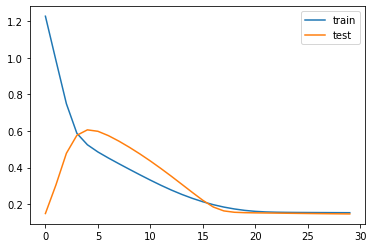

In [34]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
# Obtain predictions and inverse_transform
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))
inv_yhat = np.concatenate((test_X,yhat),axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

# Get all training predictions, create a dataframe and map back to dates so we can plot and analyse
train_y_out = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0],train_X.shape[2]))
inv_y_ = np.concatenate((train_X,train_y_out),axis=1)
inv_y_ = scaler.inverse_transform(inv_y_)
all_data = np.concatenate((inv_y_, inv_yhat),axis=0)

all_data = pd.DataFrame(all_data)
all_data.columns=['Temp_mean','Day','Holiday','Lockdown_index','Ema_90_1','LSTM_load']
data_2['LSTM_load'] = all_data['LSTM_load']
data_2['Error_LSTM'] = data_2['LSTM_load']-data_2['Load']

In [0]:
# Add forecasts from regression model for comparison
data_2 = data_2.merge(data[['Date','in_forecast_5']],how='left',on='Date')
data_2['Mixture'] = (0.3*data_2['LSTM_load']+0.7*data_2['in_forecast_5'])
data_2['Error_mix'] = data_2['Mixture']-data_2['Load']

In [37]:
# Plot series
cutoff = dt.datetime(2019,6,1)
plt_df_2 = data_2[data_2['Date']>=cutoff]
fig = go.Figure()
fig.add_trace(go.Scatter(x=plt_df_2['Date'], y=plt_df_2['Load'],
                    mode='lines',
                    name='Log load'))

#fig.add_trace(go.Scatter(x=plt_df_2['Date'], y=plt_df_2['LSTM_load'],
#                    mode='lines',
#                    name='Forecast_LSTM'))
#fig.add_trace(go.Scatter(x=plt_df_2['Date'], y=plt_df_2['in_forecast_5'],
#                    mode='lines',
#                    name='OLS_M5'))
fig.add_trace(go.Scatter(x=plt_df_2['Date'], y=plt_df_2['Mixture'],
                    mode='lines',
                    name='Mixture'))
fig.update_layout(legend_orientation='h')
fig.update_layout(
    title="Electricity load forecasting",
    xaxis_title="Date",
    yaxis_title="Log(load in MW)",
    title_x=0.5
)
fig.show()

In [38]:
# Plot errors
cutoff = dt.datetime(2000,11,1)
plt_df_2 = data_2[data_2['Date']>=cutoff]
fig = go.Figure()
fig.add_trace(go.Scatter(x=plt_df_2['Date'], y=plt_df_2['Error_mix'],
                    mode='lines',
                    name='Error_mix'))
fig.show()

In [39]:
print('Mixture error: '+ str(np.std(data_2['Error_mix'])), 'LSTM error: '+ str(np.std(data_2['Error_LSTM'])))

Mixture error: 0.0396287939782803 LSTM error: 0.04562121555368308


In [40]:
data_2

,index,Date,Temp_mean,Day,Holiday,Lockdown_index,Ema_90_1,Load,LSTM_load,Error_LSTM,in_forecast_5,Mixture,Error_mix
0,1,2017-01-02,2.0,0,0,0.00,10.206550,10.294451,10.331625,0.037174,10.376914,10.363327,0.068876
1,2,2017-01-03,2.7,1,0,0.00,10.286460,10.437069,10.363017,-0.074051,10.402022,10.390321,-0.046748
2,3,2017-01-04,4.9,2,0,0.00,10.422143,10.452967,10.427802,-0.025165,10.420095,10.422407,-0.030560
3,4,2017-01-05,1.2,3,0,0.00,10.449887,10.494623,10.441251,-0.053373,10.476745,10.466096,-0.028527
4,5,2017-01-06,2.5,4,0,0.00,10.490150,10.480395,10.436859,-0.043536,10.472005,10.461461,-0.018933
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,1240,2020-05-25,14.3,0,1,66.67,9.753361,9.780206,9.818210,0.038004,9.738876,9.762676,-0.017530
1240,1241,2020-05-26,16.0,1,0,66.67,9.777521,9.913885,9.894573,-0.019312,9.910933,9.906025,-0.007860
1241,1242,2020-05-27,15.9,2,0,66.67,9.900249,9.920466,9.936129,0.015664,9.958275,9.951632,0.031166
1242,1243,2020-05-28,17.0,3,0,66.67,9.918444,9.884741,9.910708,0.025966,9.950960,9.938884,0.054143
